# London Bike Sharing Prediction

### Metadata:

- <b> "timestamp" </b> - timestamp field for grouping the data
- <b> "cnt" </b> - the count of a new bike shares
- <b> "t1" </b> - real temperature in C
- <b> "t2" </b> - temperature in C "feels like"
- <b> "hum" </b> - humidity in percentage
- <b> "windspeed" </b> - wind speed in km/h
- <b> "weathercode" </b> - category of the weather
- <b> "isholiday" </b> - boolean field - 1 holiday / 0 non holiday
- <b> "isweekend" </b> - boolean field - 1 if the day is weekend
- <b> "season" </b> - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.

- <b> "weathe_code" category description: </b>
    1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity 2 = scattered clouds / few clouds 3 = Broken clouds 4 = Cloudy 7 = Rain/ light Rain shower/ Light rain 10 = rain with thunderstorm 26 = snowfall 94 = Freezing Fog
    
    
### Outline:

- <b> Observe Dataset </b>
- <b> Exploratory Data Analysis </b>
    - Missing values
    - Univariate analysis (Target Attribute)
    - Univariate analysis (Independent Attributes)
    - Multivariate analysis (Categorical & Numerical)
    - Feature Engineering
    
- <b> Dataset Preparation </b>
    - Scaling dataset
- <b> Modeling and Evaluation Metrics </b>
    - Linear Regression
    - XGBBoostRegressor
    - Lasso Regressor


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Observe Dataset

In [ ]:
df = pd.read_csv('../input/london-bike-sharing-dataset/london_merged.csv')

In [ ]:
df.head()

In [ ]:
df.info()

Our target attribute is <b> cnt </b> number of bikes count in a given hour. 

In [ ]:
df["Id"] = df.index + 1

In [ ]:
df.describe()

In [ ]:
xdf = df.copy()

# Exploratory Data Analysis

## Missing Values

Before deeply analysing our data, let's check the missing values on our dataset.

In [ ]:
# Let's visualize it

plt.figure(figsize = (6,8))
sns.heatmap(xdf.isnull(), cbar = False);

We don't have any missing values. Perfect

## Univariate Analysis (Target Attribute)

In [ ]:
df['cnt'].describe()

In [ ]:
# Let's check it's distriubtion

sns.displot(x = 'cnt', data = xdf, aspect = 2, height = 6, kde = True);

Let's see the number of outliers present in our target attribute. It's postively skewed, we don't want to touch the prediction data. So leaving it as it is.

In [ ]:
xdf

In [ ]:
# Scatterplot

plt.figure(figsize = (8,6))
sns.scatterplot(x = 'cnt', y = "Id", data = xdf);

As we can see, there are some amount of outliers. Let's confirm this on <b> Boxplot </b>

In [ ]:
# Boxplot

plt.figure(figsize = (8,6))
sns.boxplot(x = "cnt", data = xdf);

In [ ]:
xdf['cnt'].describe()

In [ ]:
xdf.shape

In [ ]:
## Let's normally distribute the data

## function reducing +ve skewness using Sqrt 

def sqrt_transformation(dataframe):
  return np.sqrt(dataframe)


# function for removing outliers

def remove_outliers(dataframe, column):
  q3 = dataframe[column].quantile(0.75)
  q1 = dataframe[column].quantile(0.25)
  IQR = q3 - q1
  
  upper = q3 + (1.5 * IQR)
  lower = q1 - (1.5 * IQR)
  
  dataframe = dataframe[(dataframe[column] > lower ) & (dataframe[column] < upper)]

  return dataframe



In [ ]:
# Remove outliers on 'Target Attribute'

xdf = remove_outliers(xdf,'cnt')

In [ ]:

# boxplot
plt.figure(figsize = (8,6))
sns.boxplot(x = "cnt", data = xdf);


In [ ]:
# describe
xdf['cnt'].describe()

## Univariate Analysis (Independent Variables)

In [ ]:
xdf.columns

In [ ]:
# Selecting on numerical features from dataset

numerical_df = xdf.select_dtypes(exclude='object')

In [ ]:
# Visualizing all the numerical feautures

for i in numerical_df:
  sns.displot(x = i, data = xdf, height = 6, aspect = 2, kde = True);
  plt.xlabel(i, fontsize = 15)

In [ ]:
# Let's check their scatterplots

for i in numerical_df:
  plt.figure(figsize = (8,6))
  sns.scatterplot(x = i, y = "Id", data = xdf);
  plt.xlabel(i, fontsize = 12)
  plt.ylabel("Id", fontsize = 12)

We can observe, some sort outliers below q1 on <b> hum <b> and outliers above q3 on <b> wind speed </b>. Let's confirm it on boxplot.

In [ ]:
# Boxplot

for i in numerical_df:
  plt.figure(figsize = (8,6))
  sns.boxplot(x = i, data = xdf);

<b> Observations </b>
- t1 , t2 has some outliers
- hum is negatively skewed and has outliers below q1
- wind_speed has also some outliers.
- whereas, weather_code is actually a categorical variable, we won't be fixing it.

In [ ]:
## Let's remove outliers from 'hum'

xdf = remove_outliers(xdf, 'hum')

In [ ]:
# after removoing 'hum' outlier

sns.boxplot(x = 'hum', data = xdf);

## Muttivariate Analysis


In [ ]:
# Let's see their relation with target attribute

for i in numerical_df:
  plt.figure(figsize = (8,6))
  sns.scatterplot(x = i, y = 'cnt', data = xdf);

## Categorical

In [ ]:
xdf['weather_code'].value_counts()

In [ ]:
categorical_df = ['weather_code']

In [ ]:
for i in categorical_df:
  sns.countplot(x = i, data = xdf);

In [ ]:
## with taget variable

plt.figure(figsize = (8,6))
sns.violinplot(y = 'cnt', x = 'weather_code', data = xdf);

<b> Observations </b>
- Weather code 1 has more number of cycles are shared overall.
- So, does Weather 2 but little less than Weather 1.
- Weather 3 is around, 0 - 50K
- However, Weather 10.0 and Weather 26.0 is highly populated around 0-16K. I think they are regular cyclist on any condition, they ride a bike.

## Feature Engineering

Let's extract the date.

In [ ]:
# convert date (object) into datetime

xdf['timestamp'] = pd.to_datetime(df['timestamp'], format = '%Y%m%d %H:%M:%S')

In [ ]:
xdf['timestamp']

In [ ]:
# Seperating all the year, month and hour and visualize them

xdf['year'] = xdf['timestamp'].dt.year
xdf['month'] = xdf['timestamp'].dt.month
xdf['hour'] = xdf['timestamp'].dt.hour

<b> Month

In [ ]:
# Let's see which month is the popular for cycle sharing.

plt.figure(figsize = (8,6))
sns.violinplot(x = xdf['month'] , y = 'cnt', data = xdf);

We can see <b> July </b> and <b> August </b> tend to have more number of cycles shared. People in London only use bicycle on the warmest month, we can compare our visulization with this image.

 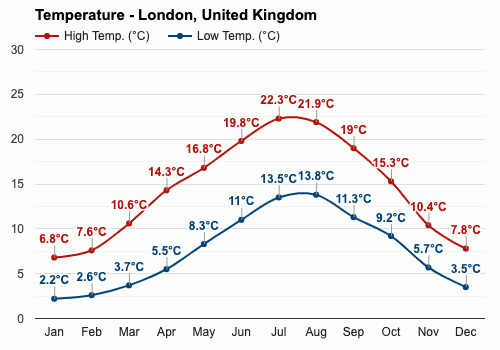

<b> Year

In [ ]:
## Let's look at the year

plt.figure(figsize = (8,6))
sns.violinplot(x = xdf['year'] , y = 'cnt', data = xdf);

The density of a Cycling has dropped over the years.

<b> Hour

In [ ]:
## Let's visualize in respect to an hour

plt.figure(figsize = (8,6))
sns.pointplot(x = xdf['hour'] , y = 'cnt', data = xdf);
plt.ylabel("Bike Shares", fontsize = 12)
plt.xlabel("Hour", fontsize = 12)

As always, peak hours are the busiest.

In [ ]:
xdf

In [ ]:
xdf.drop(['timestamp','Id'], axis = 1, inplace = True)

## Preparing Dataset

In [ ]:
X = xdf.drop('cnt', axis = 1)
y = xdf['cnt']

### Scaling Dataset

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X1 = scaler.fit_transform(X)
X = pd.DataFrame(data = X1, columns = X.columns)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state= 42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

# Modeling and Evaluation Metrics

In [ ]:
model_score = pd.DataFrame(columns = ("R2_Score","RMSE","MAE"))

### Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_log_error, mean_squared_error, make_scorer

In [ ]:

lr = LinearRegression(normalize = True)
lr.fit(X_train, y_train)

In [ ]:
lr.score(X_test, y_test)

In [ ]:
preds = lr.predict(X_test)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

mae = mean_absolute_error(y_test, preds)
print("MAE: %f" % (mae))

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

r2 = 1 - (np.sum((y_test - preds) ** 2)  / np.sum((y_test - y_test.mean()) ** 2))
print("R2:", r2)

In [ ]:
model_score = model_score.append(pd.DataFrame({"R2_Score":[r2],
                                               "RMSE":[rmse],
                                              "MAE":[mae]}, index = ['LinearRegression']))

In [ ]:
actual = pd.DataFrame(data = y_test.values, columns = ["actual"])
predicted = pd.DataFrame(data = preds, columns = ["predicted"])

final = pd.concat([actual, predicted], axis = 1)
final

### XGB Regressor

In [ ]:
from xgboost.sklearn import XGBRegressor

In [ ]:
xgbmodel = XGBRegressor()
xgbmodel.fit(X_train, y_train)

preds = xgbmodel.predict(X_test)

In [ ]:
print("Score", xgbmodel.score(X_test, y_test))

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

mae = mean_absolute_error(y_test, preds)
print("MAE: %f" % (mae))

In [ ]:
r2 = 1 - (np.sum((y_test - preds) ** 2)  / np.sum((y_test - y_test.mean()) ** 2))
print("R2:", r2)

In [ ]:
model_score = model_score.append(pd.DataFrame({"R2_Score":[r2],
                                               "RMSE":[rmse],
                                              "MAE":[mae]}, index = ['XGBoostRegressor']))

In [ ]:
actual = pd.DataFrame(data = y_test.values, columns = ["actual"])
predicted = pd.DataFrame(data = preds, columns = ["predicted"])

final = pd.concat([actual, predicted], axis = 1)
final

In [ ]:
y_test.values

### Lasso Regressor

In [ ]:
from sklearn.linear_model import Lasso

In [ ]:
ls = Lasso(alpha = 0.01)
ls.fit(X_train, y_train)

In [ ]:
preds = ls.predict(X_test)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

mae = mean_absolute_error(y_test, preds)
print("MAE: %f" % (mae))

In [ ]:
r2 = 1 - (np.sum((y_test - preds) ** 2)  / np.sum((y_test - y_test.mean()) ** 2))
print("R2:", r2)

In [ ]:
model_score = model_score.append(pd.DataFrame({"R2_Score":[r2],
                                               "RMSE":[rmse],
                                              "MAE":[mae]}, index = ['LassoRegressor']))

In [ ]:
actual = pd.DataFrame(data = y_test.values, columns = ["actual"])
predicted = pd.DataFrame(data = preds, columns = ["predicted"])

final = pd.concat([actual, predicted], axis = 1)
final

## The result

In [ ]:
model_score